In [2]:
import pandas as pd
import numpy as np

pd.set_option("display.max_colwidth", None)
# df = pd.read_json("../web-crawler/scrapy_mobiliar/mobiscraper/mobiscraper/spiders/scrape_archive/full_scrape_III_with_linkedpages.json")
# df = pd.read_json("ratgeber_pages_url.json")
# df.shape[0]


In [3]:
def save_as_json(pandas_dataframe, file_name):
    import datetime
    date_info = datetime.datetime.now().strftime("%d-%m-%y")
    pandas_dataframe.to_json(f"{file_name}_{date_info}.json", orient='records')

In [70]:
result = df['linkedpages'].apply(lambda x: len(x) == 0)
filtered_df = df[result]
filtered_df

,url,pagetitle,subtitle,introduction,summarybox,content,accordion,linkedpages
49,https://mym.mobiliar.ch/?language=de,,,,,,,[]
50,https://report.mobiliar.ch/2023/de/,,,,,,,[]
55,https://www.mobiliar.ch/hub/wohnen,,,,,,,[]
86,https://secure.mobiliar.ch/vvn-anliegen/fahrzeugwechsel?language=de,,,,,,,[]
87,https://secure.mobiliar.ch/aro-anliegen/contact?language=de,,,,,,,[]
...,...,...,...,...,...,...,...,...
1698,https://www.mobiliar.ch/hub/wohnen/inspiration,,,,,,,[]
1705,https://www.mobiliar.ch/hub/wohnen/videoartikel,,,,,,,[]
1724,https://www.mobiliar.ch/hub/wohnen/ratgeberartikel,,,,,,,[]
1725,https://www.mobiliar.ch/hub/wohnen/unserhaus/grosses-finale-in-fulenbach,,,,,,,[]


## Matrix build
To build the matrix, we need to list every single linked URL in the X-axis. The individual pages that were scraped are listed in the Y-axis.

In the first step, we need the URL of each scraped page in the form of a list. These can be found in the "url" column.

In the next step, we extract each individual URL from the column of URLs linked on the page, if it is not already in the all_linked_page_urls list, it is added.

In [2]:
all_scraped_page_urls = df.url.tolist()
len(all_scraped_page_urls)

148

In [4]:
def get_all_page_urls_of_linkedpages_column(pandas_dataframe, column_of_lists_with_linked_pages="linkedpages"):
    all_linked_page_urls = []
    for i in pandas_dataframe.index:
        list_of_linked_pages_per_url = pandas_dataframe.loc[i, column_of_lists_with_linked_pages]
        for linkedpage in list_of_linked_pages_per_url:
            if linkedpage not in all_linked_page_urls:
                all_linked_page_urls.append(linkedpage)
    return all_linked_page_urls

all_linked_page_urls = get_all_page_urls_of_linkedpages_column(df)
len(all_linked_page_urls)

NameError: name 'df' is not defined

In [4]:
# liste_der_verbindungen = []
# for i in df.index:
#     list_of_linked_pages_per_url = df.loc[i, "linkedpages"]
#     li = [df.loc[i, "url"]] * len(list_of_linked_pages_per_url)
#     data = list(zip(li, list_of_linked_pages_per_url))
#     liste_der_verbindungen += data
# len(liste_der_verbindungen)

## Fill Matrix

Next, we want to fill the matrix. If the respective page (row) in your content links to the other website as an X-axis attribute, enter True, otherwise False. 

In [38]:
# To figure out how to make it work, I've used this simple Test
liste_mit_allen_linked_urls = ["A", "B", "C", "D", "E", "F", "G", "H"]
A = ["A", "H", "D"]
B = ["D", "F"]
C = ["D"]
D = ["G", "H"]
E = ["E", "F", "H"]
F = ["C", "E"]
G = ["A", "F", "H"]
H = ["B", "G"]

liste_aller_page_urls = []
for i in range(len([A,B,C,D,F,G,H])):
    for e in [A,B,C,D,F,G,H][i]:
        if e not in liste_aller_page_urls:
            liste_aller_page_urls.append(e)
liste_aller_page_urls

test_matrix = pd.DataFrame(columns=liste_mit_allen_linked_urls)

for page_url in liste_aller_page_urls:
    ist_in_liste_mit_allen_linked_urls = [(buchstabe in page_url) for buchstabe in liste_mit_allen_linked_urls]
    new_row = dict(zip(test_matrix.columns, ist_in_liste_mit_allen_linked_urls))      
    test_matrix = pd.concat([test_matrix, pd.DataFrame([new_row])], ignore_index=True)
test_matrix = test_matrix.assign(page_url=["A", "B", "C", "D", "E", "F", "G", "H"])
test_matrix

# And a data frame with characteristics for your nodes
carac = pd.DataFrame({ 'page_url':['A', 'B', 'C', 'D'], 'color':[(0,1,0),(1,0,0),(1,0,0),(0,1,0),(0,1,0),(0,0,1),(0,1,0),(0,0,0),(0,0,1)]})

,A,B,C,D,E,F,G,H,page_url
0,True,False,False,False,False,False,False,False,A
1,False,False,False,False,False,False,False,True,B
2,False,False,False,True,False,False,False,False,C
3,False,False,False,False,False,True,False,False,D
4,False,False,False,False,False,False,True,False,E
5,False,False,True,False,False,False,False,False,F
6,False,False,False,False,True,False,False,False,G
7,False,True,False,False,False,False,False,False,H


In [5]:
def get_connection_matrix(pandas_dataframe, column_containing_list_of_all_linked_pages_per_url):

    # column_names = get_all_page_urls_of_linkedpages_column(pandas_dataframe)
    column_names = pandas_dataframe.url.tolist()

    if column_names[0] != "url":
        column_names.insert(0, "url")

    assert column_names[0] == "url", "first Element must be 'url'."
    assert column_names[1].startswith("https://"), "second Element must start with 'https://...'." 

    matrix = pd.DataFrame(columns=column_names)
    list_with_no_linked_pages = []
    all_scraped_page_urls = pandas_dataframe.url.tolist()

    for url in all_scraped_page_urls:
        idx = all_scraped_page_urls.index(url)
        list_of_linked_pages_per_url = pandas_dataframe.loc[pandas_dataframe.index[pandas_dataframe["url"]==url].tolist(), column_containing_list_of_all_linked_pages_per_url]
        is_in_list_of_all_linked_urls = [(linked_page in list_of_linked_pages_per_url[idx]) for linked_page in column_names]
        is_in_list_of_all_linked_urls[0] = url
        new_row = dict(zip(matrix.columns, is_in_list_of_all_linked_urls))      
        matrix = pd.concat([matrix, pd.DataFrame([new_row])], ignore_index=True)

    return matrix

In [ ]:
matrix = get_connection_matrix(pandas_dataframe=df, column_containing_list_of_all_linked_pages_per_url="linkedpages")
matrix

In [8]:

matrix.iloc[0].value_counts()

0
False                                                                               95
True                                                                                53
https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/ratgeber     1
Name: count, dtype: int64

In [74]:
# Number of rows that all have false values
matrix.loc[(matrix.iloc[:, 1:] == False).all(axis=1)]
# Number of columns that all have false values
len(matrix.columns[(matrix == False).all()])

,page_url,https://www.mobiliar.ch,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/tierversicherung,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/cyberversicherung,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/mietkautionsversicherung,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/wertsachenversicherung,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/gebaeudeversicherung,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/privathaftpflichtversicherung,https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/privat-rechtsschutz,...,https://www.mobiliar.ch/die-mobiliar/ueber-uns/innovation-bei-der-mobiliar,https://www.mobiliar.ch/die-mobiliar/ueber-uns/geschaeftsbericht/download-center/geschaeftsbericht-bestellen,https://www.mobiliar.ch/die-mobiliar/ueber-uns/unternehmensportraet,https://www.mobiliar.ch/die-mobiliar/ueber-uns/unternehmensportraet/die-mobiliar-praesentiert-das-leben,https://www.mobiliar.ch/die-mobiliar/ueber-uns/unternehmensportraet/189-millionen-erfolgsbeteiligung-dank-genossenschaft,https://www.mobiliar.ch/die-mobiliar/ueber-uns/innovation-bei-der-mobiliar/wir-befaehigen-fuer-die-zukunft,https://www.mobiliar.ch/die-mobiliar/ueber-uns/innovation-bei-der-mobiliar/wir-denken-zukunft,https://www.mobiliar.ch/die-mobiliar/ueber-uns/unternehmensportraet/leitbild-der-gruppe-mobiliar,https://www.mobiliar.ch/die-mobiliar/ueber-uns/unsere-werbung/werbespots-liebe-mobiliar/geisterhaus-spot-gewinnt-silber-edi,https://www.mobiliar.ch/die-mobiliar/ueber-uns/unsere-werbung/werbespots-liebe-mobiliar/25-jahre-liebe-mobiliar
49,https://mym.mobiliar.ch/?language=de,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
50,https://report.mobiliar.ch/2023/de/,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
55,https://www.mobiliar.ch/hub/wohnen,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
86,https://secure.mobiliar.ch/vvn-anliegen/fahrzeugwechsel?language=de,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
87,https://secure.mobiliar.ch/aro-anliegen/contact?language=de,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,https://www.mobiliar.ch/hub/wohnen/inspiration,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1705,https://www.mobiliar.ch/hub/wohnen/videoartikel,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1724,https://www.mobiliar.ch/hub/wohnen/ratgeberartikel,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1725,https://www.mobiliar.ch/hub/wohnen/unserhaus/grosses-finale-in-fulenbach,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [4]:
A = ["D", "H"]
B = ["A", "C"]
C = ["A", "B", "C", "D"]
D = ["B", "C", "H"]

data = {
    "url": ["A", "B", "C", "D"],
    "linkedpages": [A, B, C, D,]
}
df = pd.DataFrame(data)

all_scraped_page_urls = df.url.tolist()
column_names = df.url.tolist()
column_names.insert(0, "url")

matrix = pd.DataFrame(columns=column_names)

for page_url in all_scraped_page_urls:
    idx = all_scraped_page_urls.index(page_url)
    list_of_linked_pages_per_url = df.loc[df.index[df["url"]==page_url].tolist(), "linkedpages"]
    is_in_list_of_all_linked_urls = [(linked_page in list_of_linked_pages_per_url[idx]) for linked_page in column_names]
    is_in_list_of_all_linked_urls[0] = page_url
    new_row = dict(zip(matrix.columns, is_in_list_of_all_linked_urls))      
    matrix = pd.concat([matrix, pd.DataFrame([new_row])], ignore_index=True)

# carac = pd.DataFrame({ 'page_url':['A', 'B', 'C', 'D'], 'color':[(0,0.5,0),(0.86,0,0),(1,1,0),(0.8,0.25,0)]})
matrix

,url,A,B,C,D
0,A,False,False,False,True
1,B,True,False,True,False
2,C,True,True,True,True
3,D,False,True,True,False


In [5]:
data = {
    "url": ["A", "B", "C", "D"],
    "negative": [0.4, 0.8, 0.0, 0.1],
    "neutral": [0.2, 0.2, 0.1, 0.8],
    "positive": [0.4, 0.0, 0.9, 0.1],
}
sentiment_data = pd.DataFrame(data)
sentiment_data

,url,negative,neutral,positive
0,A,0.4,0.2,0.4
1,B,0.8,0.2,0.0
2,C,0.0,0.1,0.9
3,D,0.1,0.8,0.1


In [6]:
def get_color(input_vector):
    import numpy as np

    red = np.array([1, 0, 0])
    yellow = np.array([1, 1, 0])
    green = np.array([0, 1, 0])

    rgb = input_vector[0] * red + input_vector[1] * yellow + input_vector[2] * green

    color = "#" + "".join(f"{int(x*255):02x}" for x in rgb)
    return color


def add_color_column_of_df_to_matrix(matrix, dataframe):
    dataframe["color"] = (
        dataframe[["negative", "neutral", "positive"]]
        .apply(lambda row: np.array(row), axis=1)
        .apply(lambda row: get_color(row))
    )
    result = pd.merge(matrix, dataframe[["url", "color"]], how="left", on=["url"])
    return result

In [7]:
test_matrix = add_color_column_of_df_to_matrix(matrix, sentiment_data)
test_matrix

,url,A,B,C,D,color
0,A,False,False,False,True,#999900
1,B,True,False,True,False,#ff3300
2,C,True,True,True,True,#19ff00
3,D,False,True,True,False,#e5e500


In [7]:
def get_full_attributes_dataset_and_matrix(sentiment_data, scrape_data):
    s = pd.merge(sentiment_data, scrape_data[["url", "linkedpages"]], how="left", on=["url"]) #.insert(loc=3, column="linkedpages", value=list_of_lipages)
    m = get_connection_matrix(scrape_data, "linkedpages")
    M = add_color_column_of_df_to_matrix(m, sentiment_data)
    S = pd.merge(s, M[["url", "color"]], how="left", on=["url"])
    S = S[["url", "pagetitle", "negative", "neutral", "positive", "color", "text", "linkedpages"]]
    return M, S

sentiment_data = pd.read_json("../sentiment-analyser/saiv_28-04-24.json")
scrape_data = pd.read_json("../web-crawler/scrapy_mobiliar/mobiscraper/mobiscraper/spiders/scrape_archive/full_scrape_IV.json")
M, S = get_full_attributes_dataset_and_matrix(sentiment_data, scrape_data)
save_as_json(M, "matrix_iv")
save_as_json(S, "full_data_iv")

In [ ]:
# bad = senti.loc[senti["cluster"]==3, "url"].to_list()
bad = matrix_with_color_cluster.loc[matrix_with_color_cluster["cluster"]==3]
bad_matrix = get_connection_matrix(bad, "linkedpages")
bad_matrix

In [79]:
matrix = get_connection_matrix(pandas_dataframe=pd.read_json("beispiel.json"), column_containing_list_of_all_linked_pages_per_url="linkedpages")
sa_data = pd.read_json("../sentiment-analyser/distilbert_s_a_result_14-04-24.json")
sa_data_with_color = add_color_column_of_df_to_matrix(matrix, sa_data)

In [6]:
fw_matrix = get_connection_matrix(pandas_dataframe=pd.read_json("../web-crawler/scrapy_mobiliar/mobiscraper/mobiscraper/spiders/scrape_archive/full_scrape_III_with_linkedpages.json"), column_containing_list_of_all_linked_pages_per_url="linkedpages")
full_website = add_color_column_of_df_to_matrix(fw_matrix, pd.read_json("../sentiment-analyser/distilbert_s_a_result_14-04-24.json"))

In [10]:
# matrix = pd.read_json("/Users/romanroth/GitHub/wbth-project/graph_network/matrix_of_full_website_27-04-24.json")

# Graph

In [19]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pyvis.network import Network


In [57]:
def get_graph_from_matrix(matrix_df):
    import networkx as nx
    from pyvis.network import Network

    G = nx.DiGraph()
    for idx, row in matrix_df.iterrows():
        G.add_node(row['url'], color=row['color'], size=120)
        start_node = row["url"]
        for column in matrix_df.columns:
            if matrix_df.loc[idx,column] == True:
                end_node = column
                G.add_edge(start_node, end_node, color="#018786")
    # return G


    # isolates = list(nx.isolates(G))
    # G.remove_nodes_from(isolates)
    # for i in isolates:
    #     print(i)

    # Change size
    # d = dict(G.degree)
    # d.update((x, 1.3*y) for x, y in d.items())
    # nx.set_node_attributes(G, d, "size")

    N = Network(height='1500px', width='100%', bgcolor="#222222", font_color="white", directed=True, notebook=False)
    N.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=250, spring_strength=0.001, damping=0.09, overlap=0) 
    N.from_nx(G)
    
    # N.force_atlas_2based() # hrepulsion()
    N.show_buttons()
    # N.set_options("""
    # var options = {
    # "physics": {
    #     "enabled": false
    # }
    # }
    # """)

    # neighbor_map = N.get_adj_list()
    # print(neighbor_map)
    for node in N.nodes:
        node_id = node["id"]
        node["color"] = G.nodes[node_id].get("color", "gray")
    #     node["title"] = "    Neighbors:<br>" + "<br>".join(neighbor_map[node[""]])

    return G, N

In [ ]:
def get_graph_from_matrix(matrix_df):
    import networkx as nx
    from pyvis.network import Network

    G = nx.DiGraph()
    for idx, row in matrix_df.iterrows():
        G.add_node(row['url'], color=row['color'], size=120)
        start_node = row["url"]
        for column in matrix_df.columns:
            if matrix_df.loc[idx,column] == True:
                end_node = column
                G.add_edge(start_node, end_node, color="#018786")

    N = Network(height='1500px', width='100%', bgcolor="#222222", font_color="white", directed=True, notebook=False)
    N.barnes_hut(gravity=-80000, central_gravity=0.3, spring_length=250, spring_strength=0.001, damping=0.09, overlap=0) 
    N.from_nx(G)

    for node in N.nodes:
        node_id = node["id"]
        node["color"] = G.nodes[node_id].get("color", "gray")
    #     node["title"] = "    Neighbors:<br>" + "<br>".join(neighbor_map[node[""]])

    return G, N

In [58]:
G, N = get_graph_from_matrix(M)

In [22]:
G, N = get_graph_from_matrix(matrix_with_color_cluster.loc[matrix_with_color_cluster["cluster"]==0])

In [59]:
N.show("graph_iv.html")

In [194]:
G_1, N_1 = get_graph_from_matrix(sa_data_with_color)
N.show("ex_force_atrlas_2based.html")

In [12]:
G, N = get_graph_from_matrix(pd.read_json("matrix_of_full_website_27-04-24.json"))
# N.show("full_website.html")

# Graph analysis

In [47]:
louvain_communities = list(nx.community.louvain_communities(G))
len(louvain_communities)

113

In [ ]:
G_undirected = G.to_undirected()
louvain_communities = list(nx.community.louvain_communities(G_undirected))


louvain_communities_dict = {}
for index, component in enumerate(louvain_communities):
    for node in component:
        louvain_communities_dict[node] = index
louvain_communities_dict

In [56]:
import json
with open("louvain_communities_dict.json", "w") as outfile: 
    json.dump(louvain_communities_dict, outfile)

In [45]:
import community as community_louvain
partition = list(community_louvain.best_partition(G_undirected))
len(partition)

1746

In [24]:
scc = list(nx.strongly_connected_components(G))
print("Strongly connected components:", scc)

Strongly connected components: [{'https://secure.mobiliar.ch/mcs-osm-b2c/public/'}, {'https://cst.apps.mobiliar.ch/'}, {'https://vorsorge.mobiliar.ch/de/vs-grundlagen'}, {'https://www.mobiliar.ch/sites/default/files/peter_frey_-_schweizerische_mobiliar_lebensversicherungs-gesellschaft_ag.vcf'}, {'https://www.mobiliar.ch/sites/default/files/valery-gumy.vcf'}, {'https://www.mobiliar.ch/sites/default/files/stephan_jaeggi_-_schweizerische_mobiliar_lebensversicherungs-gesellschaft_ag.vcf'}, {'https://www.mobiliar.ch/sites/default/files/albert_wildi_-_schweizerische_mobiliar_lebensversicherungs-gesellschaft_ag_0.vcf'}, {'https://www.mobiliar.ch/sites/default/files/hans_gloor.vcf'}, {'https://www.mobiliar.ch/versicherungen-und-vorsorge/vorsorge-und-gesundheit/unfall-und-krankheit/unfallversicherung-fuer-hausangestellte/praemienrechner'}, {'https://secure.mobiliar.ch/simulation-mxs/index.html?lang=de'}, {'https://secure.mobiliar.ch/praemienrechner/casa-init?bedarf=802752&language=de'}, {'https

In [ ]:
scc_dict = {}
for index, component in enumerate(scc):
    for node in component:
        scc_dict[node] = index
scc_dict

In [31]:
import json
with open("scc_dict.json", "w") as outfile: 
    json.dump(scc_dict, outfile)

In [ ]:
# Finden schwacher Komponenten
wcc = list(nx.weakly_connected_components(G))
wcc_dict = {}
for index, component in enumerate(wcc):
    for node in component:
        wcc_dict[node] = index
wcc_dict


In [37]:
import json
with open("wcc_dict.json", "w") as outfile: 
    json.dump(wcc_dict, outfile)

In [20]:
G_example, N_es = get_graph_from_matrix(test_matrix)
N_es.show("example_graph.html")

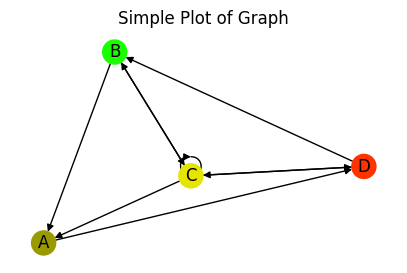

In [211]:
plt.figure(figsize=(5, 3))
# nx.draw(G_test, with_labels=True, node_color='skyblue', node_size=500, font_size=8)
plt.title('Simple Plot of Graph')
# plt.show()

nx.draw(G, with_labels=True, node_color=test_matrix['color'])
plt.show()

In [ ]:
pos = nx.spring_layout(G, iterations=20, seed=1721)
fig, ax = plt.subplots(figsize=(20, 12))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

## Graph properties

In [143]:
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

In [33]:
nodes, edges = G.order(), G.size()
print("SCC: ", nx.number_strongly_connected_components(G))
print("WCC: ", nx.number_weakly_connected_components(G))

SCC:  121
WCC:  29


In [145]:
# https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html#basic-topological-attributes

print("number of nodes:", G.number_of_nodes())
print("number of edges:", G.number_of_edges())
print("average connected nodes per node:", np.mean([d for _, d in G.degree()]))

# Compute the average shortest path length for each node
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
np.mean(average_path_lengths)

number of nodes: 1716
number of edges: 9652
average connected nodes per node: 11.249417249417249


6.113301865696317

# Degree distribution

Text(0.5, 1.0, 'network of places in Cambridge')

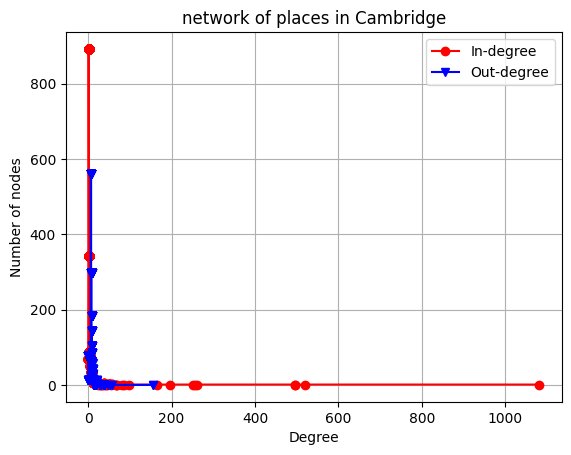

In [186]:
in_degrees = G.in_degree() # dictionary node:degree
in_values = sorted([val for (node, val) in G.in_degree()])
out_values = sorted([val for (node, val) in G.out_degree()])
in_hist = [in_values.count(x) for x in in_values]
out_hist = [out_values.count(x) for x in in_values]

plt.figure()
plt.grid(True)
plt.plot(in_values, in_hist, 'ro-') # in-degree
plt.plot(out_values, out_hist, 'bv-') # out-degree
plt.legend(['In-degree', 'Out-degree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('network of places in Cambridge')
# plt.xlim([0, 2*10**2])
# plt.savefig('./output/cam_net_degree_distribution.pdf')
# plt.close()

# Try to cluster

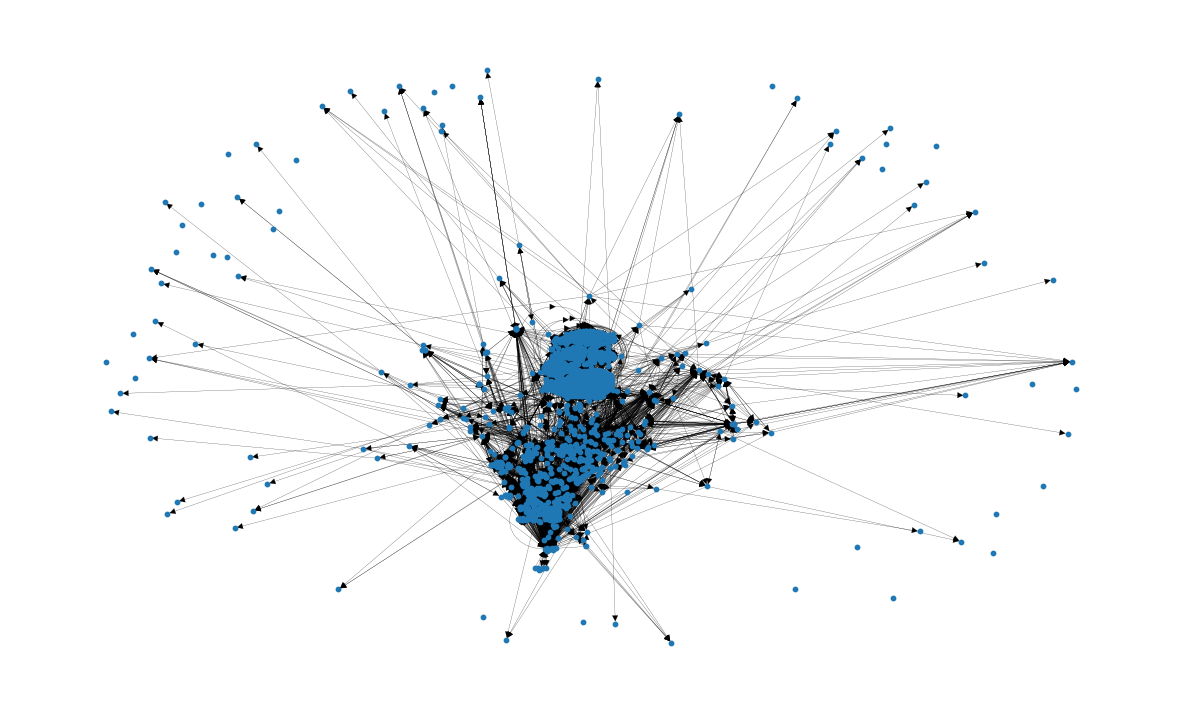

In [16]:
pos = nx.spring_layout(G, iterations=30, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [19]:
# Top ten der höchsten degree centralitys
degree_centrality = nx.centrality.degree_centrality(
    G
)  # save results in a variable to use again
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[('https://www.mobiliar.ch/die-mobiliar', 0.6224899598393574),
 ('https://www.mobiliar.ch/die-mobiliar/medien/medienmitteilungen',
  0.30579460699942623),
 ('https://www.mobiliar.ch/die-mobiliar/medien', 0.3006310958118187),
 ('https://www.mobiliar.ch/kontaktaufnahme', 0.285140562248996),
 ('https://www.mobiliar.ch/die-mobiliar/nachhaltigkeit-engagement/das-gesellschaftsengagement-der-mobiliar/praevention-und-natur',
  0.1835915088927137),
 ('https://www.mobiliar.ch/die-mobiliar/ueber-uns', 0.15490533562822717),
 ('https://www.mobiliar.ch/die-mobiliar/nachhaltigkeit-engagement/das-gesellschaftsengagement-der-mobiliar',
  0.15375788869764773),
 ('https://www.mobiliar.ch/die-mobiliar/nachhaltigkeit-engagement',
  0.15088927137119906),
 ('https://www.mobiliar.ch/versicherungen-und-vorsorge/angebote-fuer-unternehmen',
  0.12335054503729201),
 ('https://www.mobiliar.ch/die-mobiliar/nachhaltigkeit-engagement/das-gesellschaftsengagement-der-mobiliar/praevention-und-natur?utm_source=print&utm_

In [20]:
(sorted(G.degree, key=lambda item: item[1], reverse=True))[:10]

[('https://www.mobiliar.ch/die-mobiliar', 1085),
 ('https://www.mobiliar.ch/die-mobiliar/medien/medienmitteilungen', 533),
 ('https://www.mobiliar.ch/die-mobiliar/medien', 524),
 ('https://www.mobiliar.ch/kontaktaufnahme', 497),
 ('https://www.mobiliar.ch/die-mobiliar/nachhaltigkeit-engagement/das-gesellschaftsengagement-der-mobiliar/praevention-und-natur',
  320),
 ('https://www.mobiliar.ch/die-mobiliar/ueber-uns', 270),
 ('https://www.mobiliar.ch/die-mobiliar/nachhaltigkeit-engagement/das-gesellschaftsengagement-der-mobiliar',
  268),
 ('https://www.mobiliar.ch/die-mobiliar/nachhaltigkeit-engagement', 263),
 ('https://www.mobiliar.ch/versicherungen-und-vorsorge/angebote-fuer-unternehmen',
  215),
 ('https://www.mobiliar.ch/die-mobiliar/nachhaltigkeit-engagement/das-gesellschaftsengagement-der-mobiliar/praevention-und-natur?utm_source=print&utm_medium=shortcut&utm_campaign=mobirama',
  156)]

Text(0, 0.5, 'Counts')

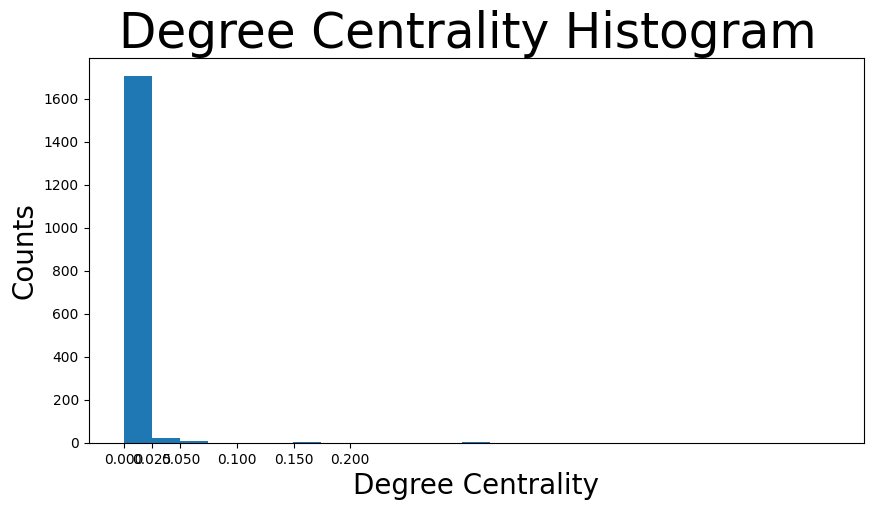

In [22]:
plt.figure(figsize=(10, 5))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-1.0203517904877661,
 1.1043177476525308,
 -0.9152189466357232,
 1.1819891306757928)

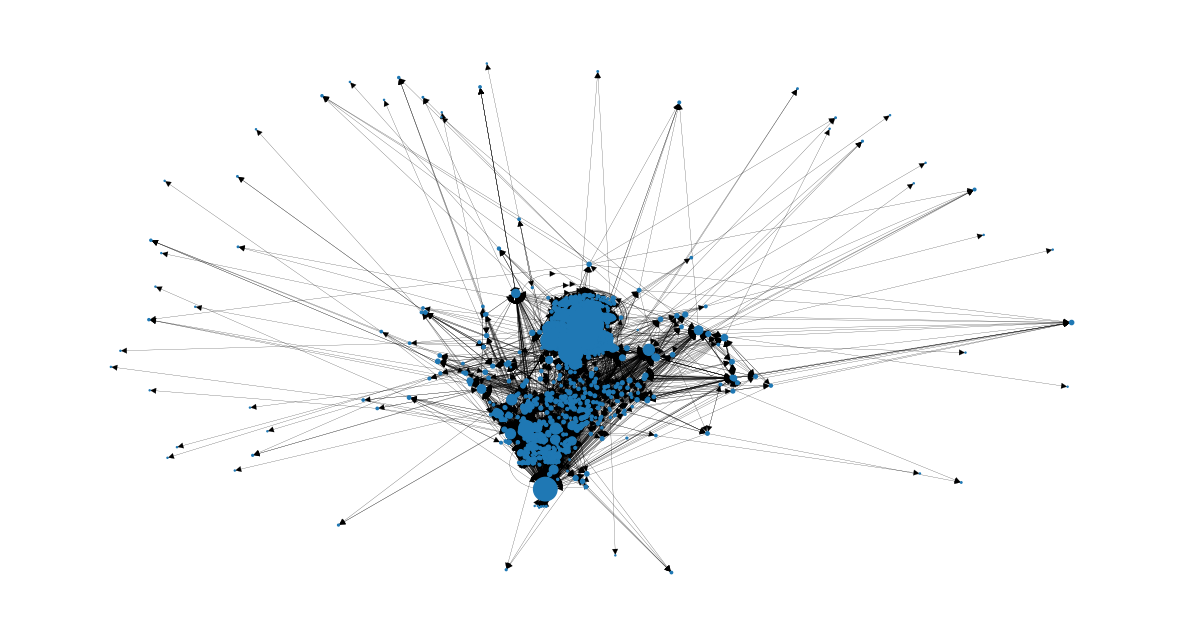

In [23]:
node_size = [
    v * 1000 for v in degree_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

In [24]:
betweenness_centrality = nx.centrality.betweenness_centrality(G)  # save results in a variable to use again
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[('https://www.mobiliar.ch/die-mobiliar', 0.40731562272879623),
 ('https://www.mobiliar.ch/die-mobiliar/medien/medienmitteilungen',
  0.32857647065731016),
 ('https://www.mobiliar.ch/die-mobiliar/medien', 0.2119712635481061),
 ('https://www.mobiliar.ch/die-mobiliar/nachhaltigkeit-engagement',
  0.18419459511194725),
 ('https://www.mobiliar.ch/die-mobiliar/medien/medienmitteilungen?page=3',
  0.12917236595029574),
 ('https://www.mobiliar.ch/die-mobiliar/nachhaltigkeit-engagement/das-gesellschaftsengagement-der-mobiliar',
  0.09608023940044393),
 ('https://www.mobiliar.ch/die-mobiliar/medien/medienmitteilungen?page=16',
  0.09507301290575122),
 ('https://www.mobiliar.ch/versicherungen-und-vorsorge/datenschutz-und-sicherheit/datenschutzerklaerung-fuer-internetseiten',
  0.09407169819820956)]

(-1.0203517904877661,
 1.1043177476525308,
 -0.9152189466357232,
 1.1819891306757928)

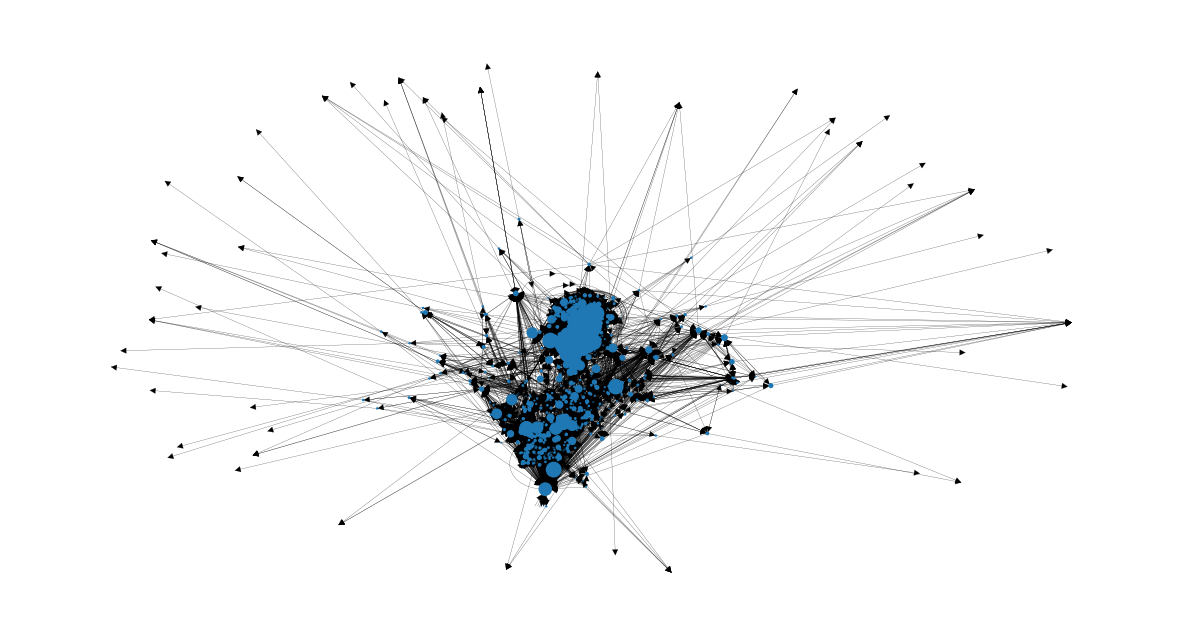

In [25]:
node_size = [
    v * 1200 for v in betweenness_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

In [17]:

average_clustering = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {average_clustering}")

Average Clustering Coefficient: 0.4494863422410941


In [42]:
louvain_communities = list(nx.community.louvain_communities(G))
len(louvain_communities)

114

In [189]:
# community detection with Louvain Community Detection Algorithm
communities = nx.community.louvain_communities(G)

# print all the communities
for i, community in enumerate(communities):
    print(f"{i+1}° Community : {community}")

1° Community : {'https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/tierversicherung/offertanfrage-haustierversicherung-hund?tier=Hund&versicherung=krankheit', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/tierversicherung/offertanfrage-haustierversicherung-katze?tier=Katze&versicherung=unfall_krankheit', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/tierversicherung/offertanfrage-haustierversicherung', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/tierversicherung/offertanfrage-haustierversicherung-katze?tier=Katze&versicherung=krankheit', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/tierversicherung'}
2° Community : {'https://www.mobiliar.ch/versicherungen-und-vorsorge/services/schaden-melden?sq=event&sc=suggestion', 'https://www.mobiliar.ch/versicherungen-und-vorsorge/wohnen-und-eigentum/ratgeber/einfacher-diebstahl-auswaerts-der-zusatzschutz-fuer-ihre-ha

In [178]:
from infomap import Infomap

node_mapping = {node: idx for idx, node in enumerate(G.nodes())}
inverse_mapping = {idx: node for node, idx in node_mapping.items()}

# Erstellen eines neuen Graphen mit ganzzahligen IDs
G_int = nx.relabel_nodes(G, node_mapping)


# Infomap-Algorithmus anwenden
im = Infomap(directed=True)
for edge in G_int.edges(data=True):
    source, target, data = edge
    weight = data['weight'] if 'weight' in data else 1.0
    im.add_link(source, target, weight)

im.run()

# Community-Informationen zu den ursprünglichen Knoten hinzufügen
for node in im.tree:
    if node.is_leaf:
        original_node = inverse_mapping[node.node_id]
        G.nodes[original_node]['community'] = node.module_id

# Ausgabe der Community-Zuordnung für ursprüngliche Knoten
print(nx.get_node_attributes(G, 'community'))


  Infomap v2.7.1 starts at 2024-04-25 09:28:07
  -> Input network: 
  -> No file output!
  -> Configuration: directed
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'directed'... 
  -> Using unrecorded teleportation to links. (Normalizing ranks after 0 power iterations with error -0.000836614173) 
  -> PageRank calculation done in 200 iterations.

  => Sum node flow: 1, sum link flow: 1
Build internal network with 1716 nodes and 9652 links...
  -> One-level codelength: 7.1645005

Trial 1/1 starting at 2024-04-25 09:28:07
Two-level compression: 26% 0.63% 
Partitioned to codelength 0.890529887 + 4.40169909 = 5.292228972 in 47 (46 non-trivial) modules.
Super-level compression: 2.9085191% to codelength 5.138303482 in 4 top modules.

Recursive sub-structure compression: 12.1888894% 7.01095549% 0% . Found 4 levels with codelength 5.098250613

=> Trial 1/1 finished in 0.149213518s with codelength 5.09825061




In [181]:
import matplotlib.pyplot as plt
from pyvis.network import Network
import networkx as nx

# Erstellen oder Übernehmen des gerichteten Graphen und der Community-Zuweisungen

# Anzahl der Communities
num_communities = len(set(nx.get_node_attributes(G, 'community').values()))

# Erstellen einer Farbpalette, die groß genug ist
cmap = plt.get_cmap('viridis')
colors = [cmap(i / num_communities) for i in range(num_communities)]

# Pyvis Netzwerk erstellen
net = Network(notebook=False, directed=True, height="750px", width="100%")

# Knoten und Kanten hinzufügen
for node in G.nodes:
    community_id = G.nodes[node]['community']
    color_index = community_id % num_communities  # Sicherstellen, dass der Index im gültigen Bereich bleibt
    color = "#{:02x}{:02x}{:02x}".format(int(colors[color_index][0]*255), int(colors[color_index][1]*255), int(colors[color_index][2]*255))
    net.add_node(node, title=f"Community: {community_id}", color=color)

for u, v in G.edges():
    net.add_edge(u, v)

# Netzwerkoptionen einstellen und anzeigen
net.set_options("""
var options = {
  "nodes": {
    "font": {
      "size": 16
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": {
      "type": "continuous"
    }
  },
  "physics": {
    "forceAtlas2Based": {
      "springLength": 100
    },
    "minVelocity": 0.75,
    "solver": "forceAtlas2Based"
  }
}
""")

net.show("network.html")


KeyError: 'community'